In [197]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy

from interval import interval, inf, imath

from safe_train import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate data

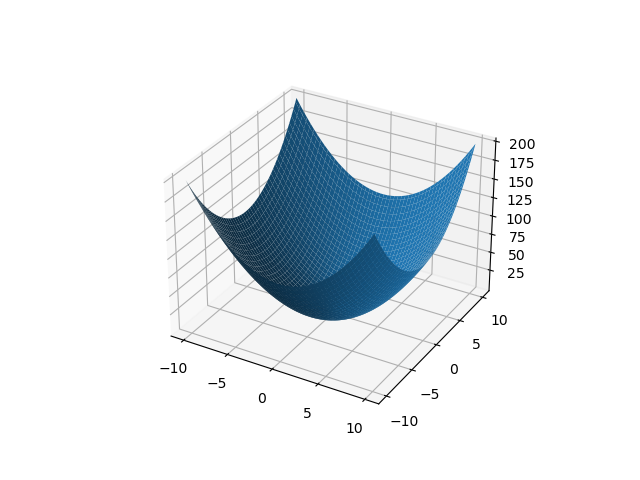

In [228]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
x, y = np.meshgrid(x,y)
z = x**2 + y**2

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
ax.plot_surface(x, y, z)
# ax.set_zlim(-1, 101)
plt.show()

In [229]:
x_array = x.reshape(-1, 1)
y_array = y.reshape(-1, 1)
z_array = z.reshape(-1, 1)
nn_x = np.hstack([x_array, y_array])

## Train network

In [230]:
normalizer = layers.Normalization(
    input_shape=[
        2,
    ],
    axis=-1,
)
normalizer.adapt(nn_x)
regression_model = tf.keras.Sequential(
    [
        normalizer, 
        # layers.Dense(units=2, activation="linear", input_shape=[2]),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        # layers.Dense(units=10, activation="sigmoid"),
        layers.Dense(units=1, activation="linear"),
    ]
)
regression_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mean_squared_error"
)

history = regression_model.fit(
    nn_x,
    z_array,
    epochs=10,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 10% of the training data.
    validation_split=0.1,
)

2023-06-23 11:45:55.905114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:45:55.917384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2023-06-23 11:45:56.889537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - ETA: 0s - loss: 626.9044

2023-06-23 11:45:59.182240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - 3s 8ms/step - loss: 626.9044 - val_loss: 90.2390
Epoch 2/10
282/282 [==============================] - 2s 7ms/step - loss: 33.4675 - val_loss: 59.2978
Epoch 3/10
282/282 [==============================] - 2s 7ms/step - loss: 20.3956 - val_loss: 64.9886
Epoch 4/10
282/282 [==============================] - 2s 7ms/step - loss: 10.9198 - val_loss: 21.2690
Epoch 5/10
282/282 [==============================] - 2s 7ms/step - loss: 106.8905 - val_loss: 29.2105
Epoch 6/10
282/282 [==============================] - 2s 7ms/step - loss: 11.2639 - val_loss: 73.2697
Epoch 7/10
282/282 [==============================] - 2s 8ms/step - loss: 7.7609 - val_loss: 48.2829
Epoch 8/10
282/282 [==============================] - 2s 8ms/step - loss: 9.7688 - val_loss: 12.6434
Epoch 9/10
282/282 [==============================] - 2s 8ms/step - loss: 7.5774 - val_loss: 54.6127
Epoch 10/10
282/282 [==============================] - 3s 10ms/step - loss: 7.8511 - val_loss:

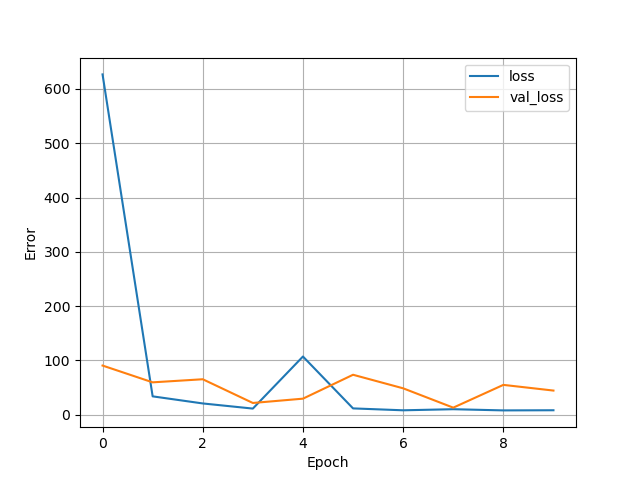

In [231]:
plot_loss(history)

In [232]:
z_predict = regression_model.predict(nn_x)
z_predict_mesh = z_predict.reshape(100, 100)

 37/313 [==>...........................] - ETA: 0s

2023-06-23 11:46:19.439893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step


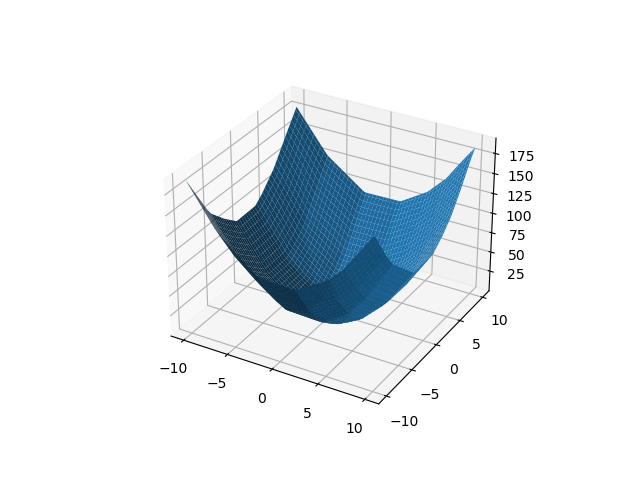

In [233]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
surf1 = ax.plot_surface(x, y, z_predict_mesh)

surf1._edgecolors2d = surf1._edgecolor3d
surf1._facecolors2d = surf1._facecolor3d

plt.show()
# plt.plot(x, y_predict, color="C1")
# plt.scatter(x, y, color="C2")
# plt.show()

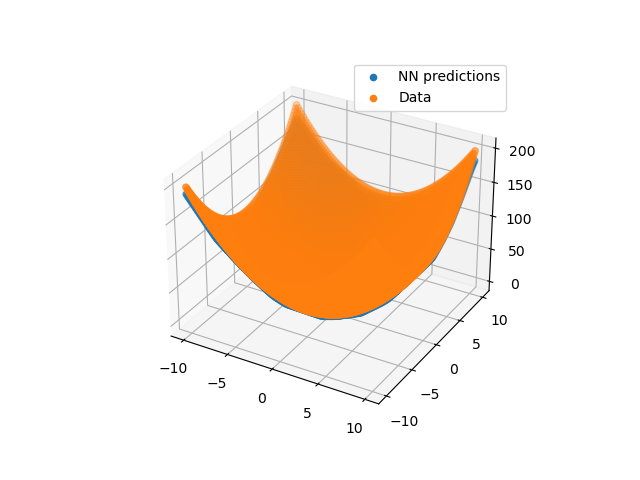

In [234]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
surf1 = ax.scatter(x, y, z_predict_mesh)
surf2 = ax.scatter(x, y, z)

ax.legend(["NN predictions", "Data"])
plt.show()
# plt.plot(x, y_predict, color="C1")
# plt.scatter(x, y, color="C2")
# plt.show()

## Analyze safety with interval tool

In [235]:
interval[-8, -5] ** 2 + interval[-8, -5] ** 2

interval([50.0, 128.0])

In [236]:
regression_model.predict([-8, -8])

1/1 [==============================] - 0s 90ms/step


2023-06-23 11:46:21.130235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[125.78101]], dtype=float32)

In [237]:
regression_model.predict([-5, -5])

1/1 [==============================] - 0s 28ms/step


array([[48.516705]], dtype=float32)

In [238]:
input_interval = [interval[-8, -5], interval[-8, -5]]
output_interval, penultimate_interval = propagate_interval(input_interval, regression_model)
output_interval

[interval([46.46801919472986, 132.66484670056857])]

In [239]:
x.reshape(-1).shape

(10000,)

In [240]:
z_predict.shape

(10000, 1)

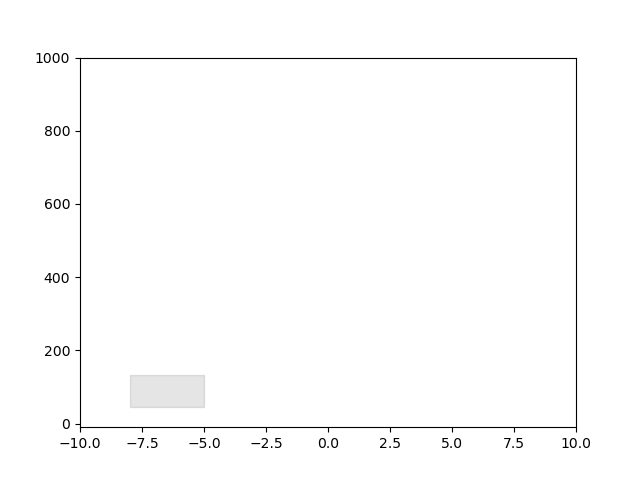

In [245]:
plot_intervals(input_interval[0], output_interval, xlim = [-10, 10], ylim = [-10, 1000])

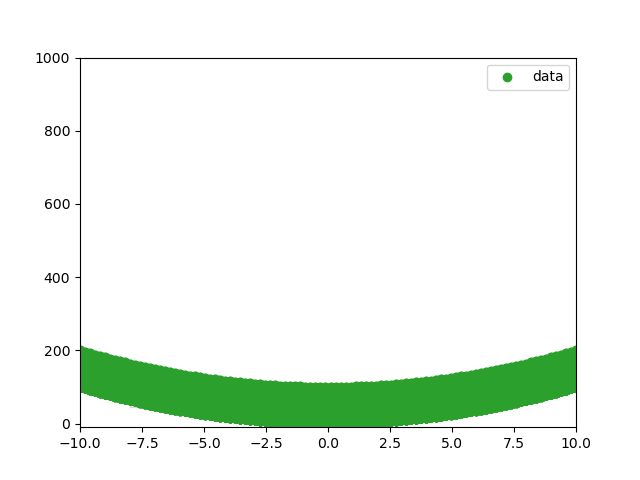

In [244]:
plot_intervals(input_interval[0], output_interval, xs = x_array, ys = z_array, xlim = [-10, 10], ylim = [-10, 1000])

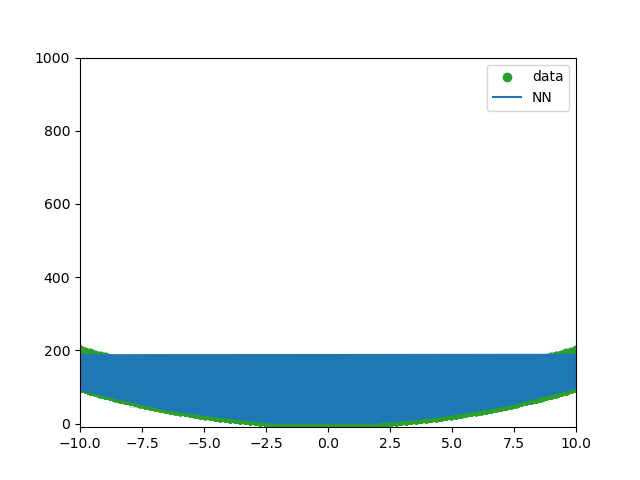

In [243]:
plot_intervals(input_interval[0], output_interval, xs = x_array, ys = z_array, y_predict = z_predict, xlim = [-10, 10], ylim = [-10, 1000])

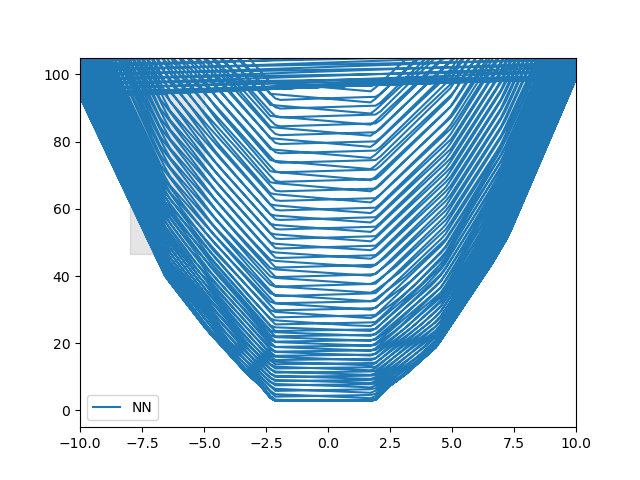

In [242]:
plot_intervals(input_interval[0], output_interval, xs=x.reshape(-1), y_predict=z_predict, xlim=[-10, 10], ylim=[-5, 105])

FAILS: needs to handle multiple inputs well

In [89]:
model = regression_model

In [90]:
model.layers[0].get_weights()

[array([ 3.7252903e-09, -3.7625432e-07], dtype=float32),
 array([34.00676, 34.00674], dtype=float32),
 10000]

In [94]:
norm_mean, norm_var, _ = model.layers[0].get_weights()
norm_mean

array([ 3.7252903e-09, -3.7625432e-07], dtype=float32)

In [99]:
norm_var

array([34.00676, 34.00674], dtype=float32)

## Simpler problem to troubleshoot

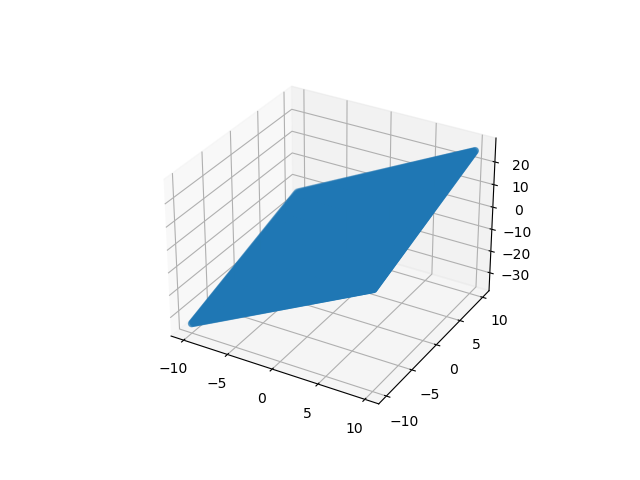

In [216]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
z_func = lambda x, y: 2*x + y - 4

x, y = np.meshgrid(x,y)
z_array = z_func(x, y)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
ax.scatter(x, y, z_array)
plt.show()

In [217]:
x_array = x.reshape(-1, 1)
y_array = y.reshape(-1, 1)
z_array_long = z_array.reshape(-1, 1)
nn_x = np.hstack([x_array, y_array])

In [218]:
normalizer = layers.Normalization(
    input_shape=[
        2,
    ],
    axis=-1,
)
normalizer.adapt(nn_x)
regression_model = tf.keras.Sequential(
    [
        normalizer, 
        layers.Dense(units=2, activation="linear", input_shape=[2]),
        # layers.Dense(units=64, activation="relu"),
        # layers.Dense(units=64, activation="relu"),
        # layers.Dense(units=64, activation="relu"),
        # layers.Dense(units=64, activation="relu"),
        # layers.Dense(units=64, activation="relu"),
        layers.Dense(units=1, activation="linear"),
    ]
)
regression_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mean_squared_error"
)

history = regression_model.fit(
    nn_x,
    z_array_long,
    epochs=10,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 10% of the training data.
    validation_split=0.1,
)

2023-06-22 14:25:01.477513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-22 14:25:01.496587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10
  9/282 [..............................] - ETA: 1s - loss: 119.6283 

2023-06-22 14:25:02.376367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - 2s 5ms/step - loss: 4.9821 - val_loss: 4.5205e-11
Epoch 2/10
  1/282 [..............................] - ETA: 1s - loss: 2.0256e-11

2023-06-22 14:25:03.859777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - 1s 5ms/step - loss: 1.4794e-12 - val_loss: 1.6266e-12
Epoch 3/10
282/282 [==============================] - 1s 5ms/step - loss: 7.0339e-13 - val_loss: 1.0324e-12
Epoch 4/10
282/282 [==============================] - 1s 5ms/step - loss: 7.1214e-13 - val_loss: 1.3671e-12
Epoch 5/10
282/282 [==============================] - 1s 5ms/step - loss: 7.1233e-13 - val_loss: 1.2813e-12
Epoch 6/10
282/282 [==============================] - 1s 5ms/step - loss: 7.8191e-13 - val_loss: 1.2719e-12
Epoch 7/10
282/282 [==============================] - 1s 5ms/step - loss: 7.3228e-13 - val_loss: 2.2427e-12
Epoch 8/10
282/282 [==============================] - 1s 5ms/step - loss: 8.5354e-13 - val_loss: 1.2166e-12
Epoch 9/10
282/282 [==============================] - 2s 5ms/step - loss: 8.6003e-13 - val_loss: 7.8964e-13
Epoch 10/10
282/282 [==============================] - 1s 5ms/step - loss: 9.8341e-13 - val_loss: 9.7351e-13


In [219]:
regression_model.predict([-8, -8])

1/1 [==============================] - 0s 45ms/step


2023-06-22 14:25:16.469590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[-27.999998]], dtype=float32)

In [220]:
z_func(*[-8, -8])

-28

In [221]:
regression_model.predict([-5, -5])

1/1 [==============================] - 0s 25ms/step


array([[-19.]], dtype=float32)

In [222]:
z_func(*[-5, -5])

-19

In [223]:
z_func(*[-1, -1])

-7

In [224]:
z_func(*[0, 0])

-4

In [249]:
input_interval = [interval[-8, -5], interval[-8, -5]]
output_interval, penultimate_interval = propagate_interval(input_interval, regression_model)
output_interval

[interval([-5.362799042689356, 470.8777658879712])]

In [226]:
input_interval = [interval[0, inf], interval[-8, -5]]
output_interval, penultimate_interval = propagate_interval(input_interval, regression_model)
output_interval

[interval([-12.00000034742053, inf])]

In [227]:
input_interval = [None, interval[-8, -5]]
output_interval, penultimate_interval = propagate_interval(input_interval, regression_model)
output_interval

[interval([-12.000000339969949, -9.000000335536742])]

## Try with one empty interval

## Test training
takeaway: make sure `shapes` match for `y, y_pred` passed to loss function. even `(100, 1)` and `(100,)` mismatch will lead to bad learning.

### Multiple regression: x, y, z

In [253]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
x, y = np.meshgrid(x, y)
z = x**2 + y**2

x_array = x.reshape(-1, 1)
y_array = y.reshape(-1, 1)
z_array = z.reshape(-1, 1)
nn_x = np.hstack([x_array, y_array])

input_interval = [interval[-8, -5], interval[-8, -5]]
desired_interval = interval[-28, -19]

normalizer = layers.Normalization(
    input_shape=[
        2,
    ],
    axis=-1,
)
normalizer.adapt(nn_x)
regression_model = tf.keras.Sequential(
    [
        normalizer,
        # layers.Dense(units=2, activation="linear", input_shape=[2]),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        # layers.Dense(units=10, activation="sigmoid"),
        layers.Dense(units=1, activation="linear"),
    ]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
loss_fn = tf.keras.losses.MeanSquaredError()

# don't project every epoch
EPOCH_TO_PROJECT = 5

epochs = 40
# epochs = 5
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch}")

    with tf.GradientTape() as tape:
        z_pred = regression_model(nn_x, training=True)  # Forward pass
        # Compute the loss value
        # (the loss function is configured in `compile()`)
        loss = loss_fn(z_array, z_pred)

    # Compute gradients
    trainable_vars = regression_model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    # print(gradients)
    # print(trainable_vars)
    # Update weights
    optimizer.apply_gradients(zip(gradients, trainable_vars))

    output_interval, penultimate_interval = propagate_interval(
        input_interval, regression_model, graph=False
    )
    if type(output_interval) is list:
        if len(output_interval) == 1:
            output_interval = output_interval[0]
        else:
            raise NotImplementedError("Output interval was interval of length > 1")
    if output_interval not in desired_interval:
        print(f"safe region test FAILED, interval was {output_interval}")
        print(regression_model.layers[-1].weights)
        if epoch % EPOCH_TO_PROJECT == 0:
            print(f"\nProjecting weights at epoch {epoch}.")
            weights = regression_model.layers[-1].weights
            print(
                f"Old weights: {np.squeeze(np.array([weight.numpy() for weight in weights]))}"
            )
            projected_weights = project_weights(
                desired_interval,
                penultimate_interval,
                np.squeeze(np.array(weights)),
            )
            print(
                f"Projected weights: {projected_weights} yield new interval: "
                f"{penultimate_interval * projected_weights[0] + projected_weights[1]}"
            )
            proj_weight, proj_bias = projected_weights
            regression_model.layers[-1].set_weights(
                [np.array([[proj_weight]]), np.array([proj_bias])]
            )
            # NOTE: assume positive weights
            # TODO: handle both signs of weights

            # print(optimizer.get_weights())
            # optimizer.set_weights(last_safe_weights)
    else:
        print(f"safe region test passed, interval was {output_interval}")

    # Update metrics (includes the metric that tracks the loss)
    regression_model.compiled_metrics.update_state(y, y_pred)
    # Return a dict mapping metric names to current value

2023-06-23 16:24:27.568667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-23 16:24:27.580307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Start of epoch 0
safe region test FAILED, interval was interval([-1.1594749547345968, 303.94654560306753])
[<tf.Variable 'dense_119/kernel:0' shape=(64, 1) dtype=float32, numpy=
array([[ 3.20495367e-01],
       [ 2.49761581e-01],
       [ 8.32225457e-02],
       [-4.43854183e-02],
       [ 1.36420056e-02],
       [ 1.48510575e-01],
       [-1.47611380e-01],
       [ 3.93420219e-01],
       [-4.53917086e-02],
       [ 9.07238722e-02],
       [ 2.24920839e-01],
       [ 2.05785036e-05],
       [ 2.53304720e-01],
       [ 3.45115095e-01],
       [-6.82683364e-02],
       [ 2.17157453e-01],
       [ 1.91229582e-03],
       [ 2.15656281e-01],
       [ 5.26018068e-02],
       [ 3.80407870e-02],
       [ 2.03326494e-01],
       [ 1.53351516e-01],
       [-4.24573645e-02],
       [ 6.95997253e-02],
       [ 1.25749767e-01],
       [ 3.89326006e-01],
       [-2.18448639e-01],
       [ 5.36309034e-02],
       [ 2.68874854e-01],
       [ 2.29732707e-01],
       [-5.88102564e-02],
       [ 3.2980

/var/folders/4w/c05_ppdx6n9_tx33rmpnzh600000gn/T/ipykernel_90471/2223237322.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f"Old weights: {np.squeeze(np.array([weight.numpy() for weight in weights]))}"
/var/folders/4w/c05_ppdx6n9_tx33rmpnzh600000gn/T/ipykernel_90471/2223237322.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.squeeze(np.array(weights)),


AttributeError: 'interval' object has no attribute 'inf'

In [254]:
test_interval = [interval([0.17749245743887973, 40.715509778405405]), interval([1.3693407866030003, 39.00241526956424]), interval([0.0]), interval([0.0, 2.8528582891451904]), interval([0.0, 0.8297828604382264]), interval([0.0, 26.46248532465599]), interval([0.0]), interval([5.1643618056622325, 51.965985161668776]), interval([0.0, 4.449784483001119]), interval([0.0, 12.181961657602645]), interval([1.1487307343228501, 36.84628332367279]), interval([0.0]), interval([0.0, 10.67893006000102]), interval([0.0, 32.31041089071087]), interval([0.0, 4.428521101926773]), interval([0.0, 33.27413406123338]), interval([0.0, 1.173106527682179]), interval([0.0, 5.763051345125981]), interval([0.0]), interval([0.0, 0.0593642406942681]), interval([1.1042434945592472, 42.40602482858007]), interval([0.0, 48.153185864747876]), interval([0.0, 2.093169161648054]), interval([0.0, 1.5303758911667666]), interval([1.5546250524211334, 41.40633134363574]), interval([1.2690299589762726, 44.50031948515337]), interval([0.0, 8.2281692197887]), interval([0.0, 0.3814058534273029]), interval([0.0, 29.90513713529191]), interval([0.0, 33.562458829446015]), interval([0.0, 0.7613352551489034]), interval([0.0, 38.30264206972309]), interval([0.0]), interval([0.0, 6.324824304874891]), interval([2.4997606995947597, 37.87439927718122]), interval([2.5371649489848416, 42.506682277456136]), interval([0.002846090267297985, 42.09635439199396]), interval([0.0]), interval([0.0, 0.6057659663937741]), interval([0.0, 12.80103993487166]), interval([0.0, 19.2486105128124]), interval([0.0, 37.93811481829238]), interval([2.968866596288945, 45.56460879954275]), interval([4.537518103822291, 51.34208899504068]), interval([0.0, 10.83174511415565]), interval([0.0, 0.2774448181623927]), interval([0.0]), interval([0.0, 29.00540786959906]), interval([0.08301538662180619, 35.51933660793823]), interval([1.0847326840759233, 38.7511647446967]), interval([0.0, 39.20136368640528]), interval([0.0, 42.341402156523365]), interval([0.0, 34.25962623911843]), interval([0.0, 48.34615648698638]), interval([2.4355944472457822, 39.57223969649944]), interval([0.0, 13.039277868905055]), interval([0.0, 4.195586380412922]), interval([0.0]), interval([0.0, 3.050183749047207]), interval([0.0]), interval([0.0, 0.1519885564424282]), interval([0.6696018918771051, 34.230603299831806]), interval([0.0, 30.686249110719995]), interval([5.5374481194296585, 50.683586670818116])]
len(test_interval)

64

### 2 dimensional

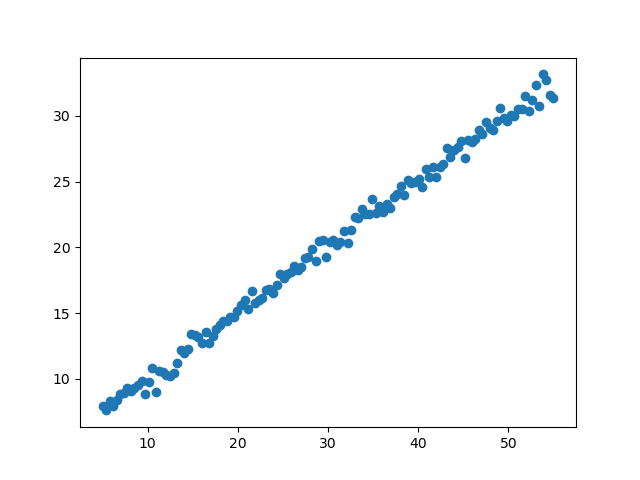

In [405]:
x, y = generate_data(NOISE_STD=0.5, n=128)
plt.figure()
plt.scatter(x, y)
plt.show()

### With `model.fit`

Works perfectly, as expected

2023-06-26 11:24:48.222294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-26 11:24:48.233757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-26 11:24:48.488316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-26 11:24:48.854503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


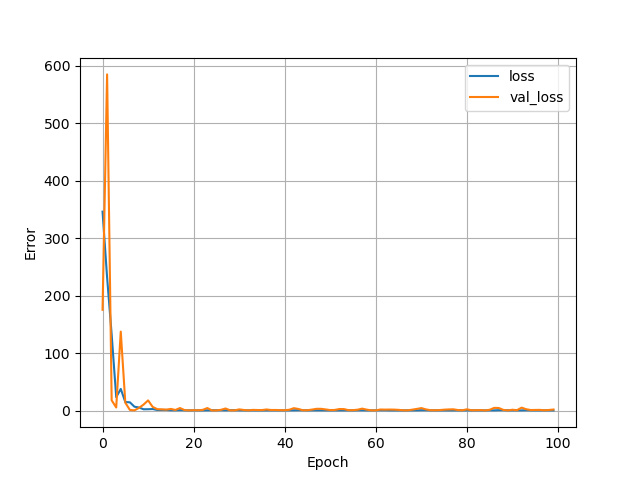

4/4 [==============================] - 0s 18ms/step


2023-06-26 11:24:52.253196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


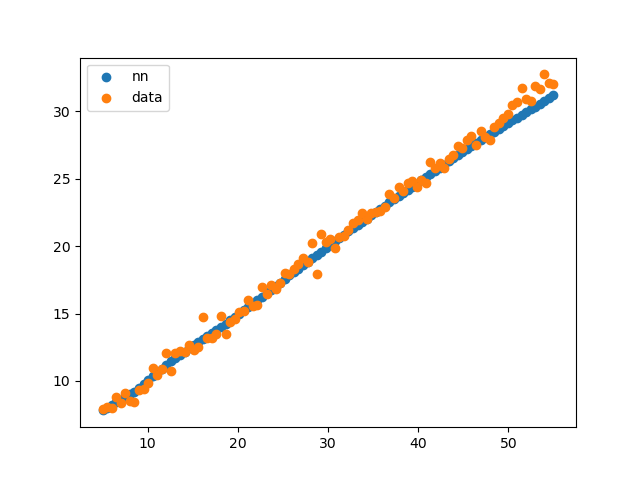

In [449]:
normalizer = layers.Normalization(
    input_shape=[
        1,
    ],
    axis=None,
)
normalizer.adapt(x)
regression_model = tf.keras.Sequential(
    [
        normalizer, 
        layers.Dense(units=1, activation="linear", input_shape=[1]),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        # layers.Dense(units=10, activation="sigmoid"),
        layers.Dense(units=1, activation="linear"),
    ]
)
regression_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mean_squared_error"
)
history = regression_model.fit(
    x,
    y,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 10% of the training data.
    validation_split=0.1,
)

plot_loss(history)

y_pred = regression_model.predict(x)

plt.figure()
plt.scatter(x, y_pred)
plt.scatter(x, y)
plt.legend(["nn", "data"])
plt.show()

### Manual

#### Batching

In [489]:
## set up batches
rng = np.random.default_rng()
batch_size = 32

train_dataset = np.vstack([x,y]).T
train_dataset

rng.shuffle(train_dataset)  # in-place

x_shuffled = train_dataset[:, 0]
y_shuffled = train_dataset[:, 1]

x_batched = np.split(x_shuffled, np.arange(batch_size,len(x_shuffled),batch_size))
y_batched = np.split(y_shuffled, np.arange(batch_size,len(y_shuffled),batch_size))

dataset_batched = list(zip(x_batched, y_batched))

#### Train loop

2023-06-26 14:24:48.215786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-26 14:24:48.229915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 18ms/step


2023-06-26 14:24:50.933703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


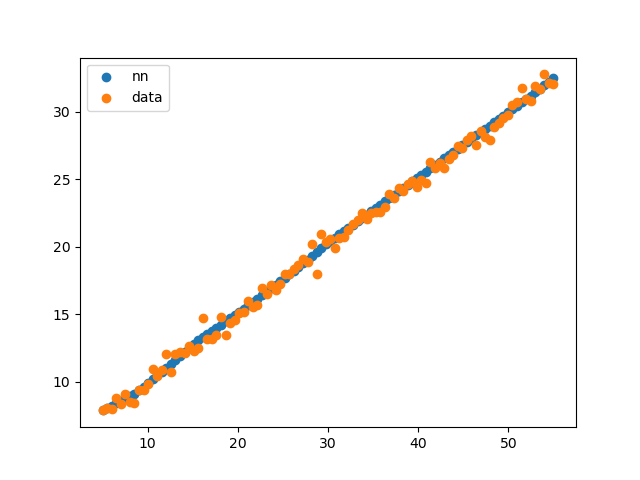

In [726]:
normalizer = layers.Normalization(
    input_shape=[
        1,
    ],
    axis=None,
)
normalizer.adapt(x)
regression_model = tf.keras.Sequential(
    [
        normalizer, 
        layers.Dense(units=1, activation="linear", input_shape=[1]),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=4, activation="relu"),
        # layers.Dense(units=10, activation="sigmoid"),
        layers.Dense(units=1, activation="linear"),
    ]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
loss_fn = tf.keras.losses.MeanSquaredError()

# don't project every epoch
EPOCH_TO_PROJECT = 5

# epochs = 500
epochs = 50
epoch_fraction = 0.1
report_every_epoch = int(epochs * epoch_fraction)
for epoch in range(epochs):
    # if epoch % report_every_epoch == 0:
        # print(f"on epoch {epoch}")
    for step, (x_batch_train, y_batch_train) in enumerate(dataset_batched):
        with tf.GradientTape() as tape:
            y_pred = regression_model(x_batch_train, training=True)  # Forward pass
            # IMPORTANT: squeeze to match dimensions before passing to loss
            y_pred = tf.squeeze(y_pred)
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = loss_fn(y_batch_train, y_pred)

        # Compute gradients
        trainable_vars = regression_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # print(gradients)
        # print(trainable_vars)
        # Update weights
        optimizer.apply_gradients(zip(gradients, trainable_vars))
# print(f"done training")
        
y_pred = regression_model.predict(x)

plt.figure()
plt.scatter(x, y_pred)
plt.scatter(x, y)
plt.legend(["nn", "data"])
plt.show()        

In [727]:
out, penum = propagate_interval([interval[10, 20]], regression_model)
out

[interval([9.571476006775303, 15.403725160093835])]

In [728]:
penum

[interval([0.0]),
 interval([0.0]),
 interval([9.113762892534101, 15.826600313325638]),
 interval([13.558799313520186, 24.692320094804693])]

In [729]:
# true function
interval[10, 20] * 0.5 + 5

interval([10.0, 15.0])

## Projection with multiple final nodes

In [730]:
input_intervals = penum
input_intervals

[interval([0.0]),
 interval([0.0]),
 interval([9.113762892534101, 15.826600313325638]),
 interval([13.558799313520186, 24.692320094804693])]

In [731]:
weights = regression_model.layers[-1].weights
weights

[<tf.Variable 'dense_709/kernel:0' shape=(4, 1) dtype=float32, numpy=
 array([[ 0.6155498 ],
        [-0.7584276 ],
        [ 0.08506278],
        [ 0.4725582 ]], dtype=float32)>,
 <tf.Variable 'dense_709/bias:0' shape=(1,) dtype=float32, numpy=array([2.3889122], dtype=float32)>]

In [732]:
theta = np.squeeze(np.vstack([weight.numpy() for weight in weights]).flatten())
theta

array([ 0.6155498 , -0.7584276 ,  0.08506278,  0.4725582 ,  2.3889122 ],
      dtype=float32)

In [809]:
input_intervals = [interval[28.3, 49.1], interval[2, 5]]

In [810]:
theta = np.array([0.148, 0.377, 1.79])

In [811]:
input_intervals[0] * theta[0] + input_intervals[1]*theta[1] + theta[2]

interval([6.732399999999999, 10.9418])

In [812]:
goal_interval = interval[10, 15]
goal_interval

interval([10.0, 15.0])

In [813]:
shift_lower = np.array(([0] * len(input_intervals)) + [goal_interval[0].inf])
shift_lower

array([ 0.,  0., 10.])

In [814]:
direction_lower = np.array([1] + [-input_interval[0].inf for input_interval in input_intervals][::-1])
direction_lower

array([  1. ,  -2. , -28.3])

In [815]:
project_lower = (
    (direction_lower @ (theta - shift_lower))
    / (direction_lower @ direction_lower)
    * direction_lower
)
project_lower

array([ 0.28755413, -0.57510827, -8.13778196])

In [816]:
param_lower = project_lower + shift_lower
param_lower

array([ 0.28755413, -0.57510827,  1.86221804])

In [817]:
shift_upper = np.array(([0] * len(input_intervals)) + [goal_interval[0].sup])
shift_upper

array([ 0.,  0., 15.])

In [818]:
# direction_upper = np.array([1] + [-input_interval[0].sup for input_interval in input_intervals])
direction_upper = np.array([1] + [-input_interval[0].sup for input_interval in input_intervals][::-1])
direction_upper

array([  1. ,  -5. , -49.1])

In [819]:
project_upper = (
    (direction_upper @ (theta - shift_upper))
    / (direction_upper @ direction_upper)
    * direction_upper
)
project_upper

array([  0.26545935,  -1.32729675, -13.03405411])

In [820]:
param_upper = project_upper + shift_upper
param_upper

array([ 0.26545935, -1.32729675,  1.96594589])

In [821]:
theta

array([0.148, 0.377, 1.79 ])

In [822]:
best_params = min([param_upper, param_lower], key=lambda param: np.linalg.norm(theta - param))
best_params

array([ 0.28755413, -0.57510827,  1.86221804])

In [823]:
input_intervals[0] * best_params[0] + input_intervals[1] * best_params[1] + best_params[2]

interval([7.124458673019891, 14.830909429326585])

In [830]:
input_intervals = [interval[28.3, 49.1], interval[0]]
input_intervals

[interval([28.3, 49.1]), interval([0.0])]

In [832]:
best_params = [0.240385, 0.377, 3.19712]
best_params

[0.240385, 0.377, 3.19712]

In [836]:
input_intervals[0] * 0.158 + 1.79

interval([6.2614, 9.5478])

In [833]:
input_intervals[0] * best_params[0] + input_intervals[1] * best_params[1] + best_params[2]

interval([10.0000155, 15.0000235])

In [837]:
interval[28.3, 49.1] * 0.289699 + interval[1,3] * -0.512874 + 2.31438

interval([8.9742397, 16.0257269])

In [840]:
interval[28.3, 49.1] * 0.240385 + interval[1,3] * 0 + 3.19712

interval([10.0000155, 15.0000235])

In [839]:
28.3 * 0.289699 + 1 * -0.512874 + 2.31438

9.9999877

In [838]:
49.1 * 0.289699 + 3 * -0.512874 + 2.31438

14.999978899999999